In [ ]:
# Install required libraries
!pip install scikit-image opencv-python-headless tensorflow


from google.colab import drive

data_dir = '/content/drive/MyDrive/MLDATA/data'


In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_images_and_labels(data_dir, img_size=(64, 64)):
    images, labels = [], []
    folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    for label in folders:
        class_dir = os.path.join(data_dir, label)
        for i, img_name in enumerate(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# ~1500 images for SVM, rest for NN
MAX_SVM = 1500
data_dir = '/content/drive/MyDrive/MLDATA/data'
X_all, y_all = load_images_and_labels(data_dir, img_size=(64, 64))
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)
X_all = X_all.astype('float32') / 255.0

# For SVM limiting to 1500 samples
X_small, y_small = X_all[:MAX_SVM], y_encoded[:MAX_SVM]
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [ ]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import cv2

def extract_hog_features_fast(images):
    feat_list = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
        # Simpler HOG for speed, fewer features:
        features = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
        feat_list.append(features)
    return np.array(feat_list)

X_svm_hog = extract_hog_features_fast(X_small)
svm = SVC(kernel='linear', max_iter=1500)
svm.fit(X_svm_hog, y_small)
y_pred_svm = svm.predict(X_svm_hog)
print("SVM Accuracy (subsample):", accuracy_score(y_small, y_pred_svm))

# Get the unique labels present in the small subsample
unique_labels_small = np.unique(y_small)
# Get the corresponding target names for these labels
target_names_small = le.inverse_transform(unique_labels_small)

print(classification_report(y_small, y_pred_svm, labels=unique_labels_small, target_names=target_names_small))

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Accuracy (subsample): 1.0
                       precision    recall  f1-score   support

 Potato___Late_blight       1.00      1.00      1.00      1000
Tomato_Bacterial_spot       1.00      1.00      1.00       500

             accuracy                           1.00      1500
            macro avg       1.00      1.00      1.00      1500
         weighted avg       1.00      1.00      1.00      1500



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(le.classes_)

model_cnn = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = model_cnn.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print("CNN Test Accuracy:", test_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3584 - loss: 1.9140 - val_accuracy: 0.6898 - val_loss: 0.9130
Epoch 2/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7146 - loss: 0.8693 - val_accuracy: 0.7807 - val_loss: 0.6299
Epoch 3/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7934 - loss: 0.6088 - val_accuracy: 0.8031 - val_loss: 0.5512
Epoch 4/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8298 - loss: 0.4954 - val_accuracy: 0.8453 - val_loss: 0.4554
Epoch 5/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8580 - loss: 0.4121 - val_accuracy: 0.8687 - val_loss: 0.3840
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8593 - loss: 0.4193
CNN Test Accuracy: 0.847451388835907


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=outputs)

model_resnet.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history_res = model_resnet.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))
test_loss2, test_acc2 = model_resnet.evaluate(X_test, y_test)
print("ResNet50 Test Accuracy:", test_acc2)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
398/398 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.1692 - loss: 2.4513 - val_accuracy: 0.2934 - val_loss: 2.2333
Epoch 2/3
398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2479 - loss: 2.2370 - val_accuracy: 0.3396 - val_loss: 2.1200
Epoch 3/3
398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2913 - loss: 2.1388 - val_accuracy: 0.3594 - val_loss: 2.0014
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3507 - loss: 2.0020
ResNet50 Test Accuracy: 0.34800148010253906


SVM Classification Report:
                       precision    recall  f1-score   support

 Potato___Late_blight       1.00      1.00      1.00      1000
Tomato_Bacterial_spot       1.00      1.00      1.00       500

             accuracy                           1.00      1500
            macro avg       1.00      1.00      1.00      1500
         weighted avg       1.00      1.00      1.00      1500

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
CNN Classification Report:
                                             precision    recall  f1-score   support

                      Potato___Early_blight       0.93      0.91      0.92       152
                       Potato___Late_blight       0.73      0.78      0.75       150
                           Potato___healthy       0.80      0.70      0.74        23
                      Tomato_Bacterial_spot       0.93      0.90      0.91       319
                        Tomato_Early_blight       0.80      0.45      0.57       150
               

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


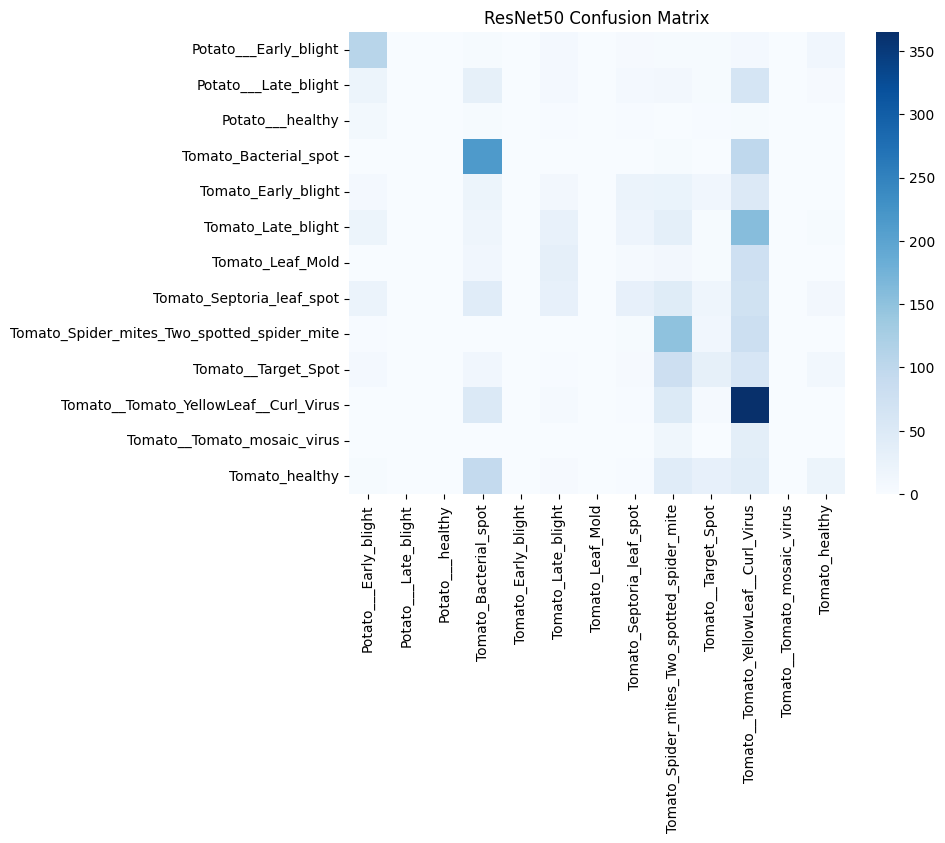

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# SVM Report
print("SVM Classification Report:")
# Use y_small and y_pred_svm for the SVM report
print(classification_report(y_small, y_pred_svm, target_names=le.inverse_transform(np.unique(y_small))))


# CNN
y_pred_cnn = model_cnn.predict(X_test).argmax(axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=le.classes_))

# ResNet50
y_pred_resnet = model_resnet.predict(X_test).argmax(axis=1)
print("ResNet50 Classification Report:")
print(classification_report(y_test, y_pred_resnet, target_names=le.classes_))

# Confusion Matrix (ResNet50 example):
cm = confusion_matrix(y_test, y_pred_resnet)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("ResNet50 Confusion Matrix")
plt.show()

In [ ]:
model_cnn.save("model.h5")


In [ ]:

import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

model = tf.keras.models.load_model("model.h5")

class_names = le.classes_


def predict_disease(img):

    img = img.resize((64, 64))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Model prediction
    preds = model.predict(img_array)
    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds) * 100

    output_text = f"Predicted Disease: {predicted_class} (Confidence: {confidence:.2f}%)"
    print("Prediction output:", output_text) # Keep the print statement for debugging

    return output_text

demo = gr.Interface(
    fn=predict_disease,
    inputs=gr.Image(type="pil", label="Upload Leaf Image"),
    outputs=gr.Label(label="Predicted Disease"), # Simplified output
    title="🌿 Plant Disease Classifier",
    description="Upload an image of a plant leaf to identify the disease using the trained CNN model."
)


demo.launch(debug=True, share=True, inline=False)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8f871982dc37e54548.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Prediction output: Predicted Disease: Tomato__Tomato_YellowLeaf__Curl_Virus (Confidence: 83.55%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction output: Predicted Disease: Tomato_Early_blight (Confidence: 82.01%)
